In [47]:
!pip install riroriro
!pip install nexusformat
!pip install visualkeras
!pip install git+https://github.com/PyFstat/PyFstat@python37

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.8/989.8 kB 20.9 MB/s eta 0:00:0000:01
  Cloning https://github.com/PyFstat/PyFstat (to revision python37) to /tmp/pip-req-build-qtem4ry_
  Running command git clone --filter=blob:none --quiet https://github.com/PyFstat/PyFstat /tmp/pip-req-build-qtem4ry_
  Running command git checkout -b python37 --track origin/python37
  Switched to a new branch 'python37'
  Branch 'python37' set up to track remote branch 'python37' from 'origin'.
  Resolved https://github.com/PyFstat/PyFstat to commit 73ad1acdc9385a234727abf3eb9f93c9298fc5e5
  Preparing metadata (setup.py) ... done


In [2]:
!python --version

Python 3.7.12


In [3]:
!pip freeze > requirement.txt

In [48]:
import os
import h5py
import gc
import glob
import math
import random
import warnings
import pyfstat

# librosa: python lib for musio n audio analysis
import librosa
import librosa.display

import numpy as np
import pandas as pd
import seaborn as sns

import riroriro.inspiralfuns as ins
import riroriro.mergerfirstfuns as me1
import riroriro.matchingfuns as mat
import riroriro.mergersecondfuns as me2

import tensorflow as tf
from scipy.signal import istft
from tensorflow.keras import regularizers
from tensorflow.keras import layers
import tensorflow_addons as tfa
import visualkeras

from pathlib import Path
from scipy import stats
from tqdm.notebook import tqdm
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from tensorflow.keras.utils import plot_model
from sklearn.model_selection   
import train_test_split

import pandas as pd
import numpy as np
from pathlib import Path
import random
import h5py
import nexusformat.nexus as nx

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

SyntaxError: invalid syntax (3983214041.py, line 37)

In [5]:
DATA_PATH = Path('../input/g2net-detecting-continuous-gravitational-waves')
TRAIN_PATH = DATA_PATH/'train'
TEST_PATH = DATA_PATH/'test'
train_example_with_signal_path = TRAIN_PATH/'cc561e4fc.hdf5'
train_example_without_signal_path = TRAIN_PATH/'fb6db0d08.hdf5'

In [6]:
with h5py.File(train_example_with_signal_path, "r") as f:
    ID_key = list(f.keys())[0]
    print(f"ID: {ID_key} \n")

ID: cc561e4fc 



In [7]:
train_labels = pd.read_csv(DATA_PATH/'train_labels.csv')
train_labels.head(10)

id  target
0  001121a05       1
1  004f23b2d       1
2  00a6db666       1
3  00f36a6ac       1
4  010a387db       1
5  0197bacf8       1
6  01b8b67f3       1
7  01bcf6533       0
8  01dba9731       1
9  021248995       1

In [8]:
# f.visitsitems() recursively visits all objects in the file and applies a user-defined function to each object 

def print_name_and_type(name, obj):
    print(name, type(obj))
    
with h5py.File(train_example_with_signal_path, "r") as f:
    f.visititems(print_name_and_type)
    f.close

cc561e4fc <class 'h5py._hl.group.Group'>
cc561e4fc/H1 <class 'h5py._hl.group.Group'>
cc561e4fc/H1/SFTs <class 'h5py._hl.dataset.Dataset'>
cc561e4fc/H1/timestamps_GPS <class 'h5py._hl.dataset.Dataset'>
cc561e4fc/L1 <class 'h5py._hl.group.Group'>
cc561e4fc/L1/SFTs <class 'h5py._hl.dataset.Dataset'>
cc561e4fc/L1/timestamps_GPS <class 'h5py._hl.dataset.Dataset'>
cc561e4fc/frequency_Hz <class 'h5py._hl.dataset.Dataset'>


In [9]:
with h5py.File(train_example_with_signal_path, "r") as f:
    
    # get first object name/key; this is the data point ID
    ID_key = list(f.keys())[0]
    print(f"ID: {ID_key} \n")
    print(list(f[ID_key].keys()), "\n")
    
    # Retrieve the Livingston decector data
    print(f"- {list(f[ID_key].keys())[1]}")
    L1_SFTs = f[ID_key]['L1']['SFTs']
    print(f"-- SFTs amplitudes: {L1_SFTs.shape}")
    L1_ts = f[ID_key]['L1']['timestamps_GPS']
    print(f"-- timestamps: {L1_ts.shape} \n")
    
    # Retrieve the Hanford decector data
    print(f"- {list(f[ID_key].keys())[0]}")
    H1_SFTs = f[ID_key]['H1']['SFTs']
    print(f"-- SFTs amplitudes: {H1_SFTs.shape}")
    H1_ts = f[ID_key]['H1']['timestamps_GPS']
    print(f"-- timestamps: {H1_ts.shape} \n")

#     # Retrieve the frequency data
    freq_data = np.array(f[ID_key]['frequency_Hz'])
    print(f"- Frequency data: {freq_data.shape} \n")

ID: cc561e4fc 

['H1', 'L1', 'frequency_Hz'] 

- L1
-- SFTs amplitudes: (360, 4655)
-- timestamps: (4655,) 

- H1
-- SFTs amplitudes: (360, 4570)
-- timestamps: (4570,) 

- Frequency data: (360,) 



In [10]:
def extract_data_from_hdf5(path, labels):
    '''
    Extracts data from hdf5 file and puts it into a dict. It also adds the label
    '''
    
    data = {}
    
    with h5py.File(path, "r") as f:

        ID_key = list(f.keys())[0]

        # Retrieve the frequency data
        data['freq'] = np.array(f[ID_key]['frequency_Hz'])

        # Retrieve the Livingston decector data
        data['L1_SFTs_amplitudes'] = np.array(f[ID_key]['L1']['SFTs'])
        data['L1_ts'] = np.array(f[ID_key]['L1']['timestamps_GPS'])

        # Retrieve the Hanford decector data
        data['H1_SFTs_amplitudes'] = np.array(f[ID_key]['H1']['SFTs'])
        data['H1_ts'] = np.array(f[ID_key]['H1']['timestamps_GPS'])
        
        # Get label from training labels if in training set
        data['label'] = labels.loc[labels.id==ID_key].target.item()
        
    return data

In [11]:
def extract_data_from_hdf5_reduced(path, labels):
    '''
    Extracts data from hdf5 file and puts it into a dict. It also adds the label
    '''
    
    data = {}
    
    with h5py.File(path, "r") as f:

        ID_key = list(f.keys())[0]

        # Retrieve the frequency data
        data['id'] = ID_key
        data['freq'] = np.array(f[ID_key]['frequency_Hz'])

        # Retrieve the Livingston decector data
        data['L1_ts'] = np.array(f[ID_key]['L1']['timestamps_GPS'])

        # Retrieve the Hanford decector data
        data['H1_ts'] = np.array(f[ID_key]['H1']['timestamps_GPS'])
        
        # Get label from training labels if in training set
        data['label'] = labels.loc[labels.id==ID_key].target.item()
        
    return data

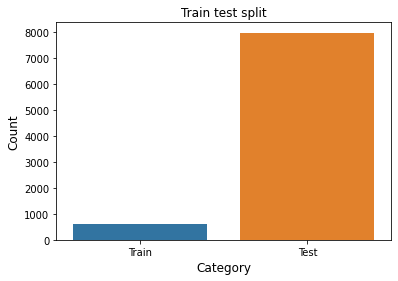

 Ratio of Test to Train split: 13.225538971807628


In [12]:
plt.figure(figsize=(6,4))
sns.barplot(x=['Train', 'Test'], y=[len(os.listdir(TRAIN_PATH)), len(os.listdir(TEST_PATH))]);
plt.title(f'Train test split', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()
print(f" Ratio of Test to Train split: {len(os.listdir(TEST_PATH))/len(os.listdir(TRAIN_PATH))}")

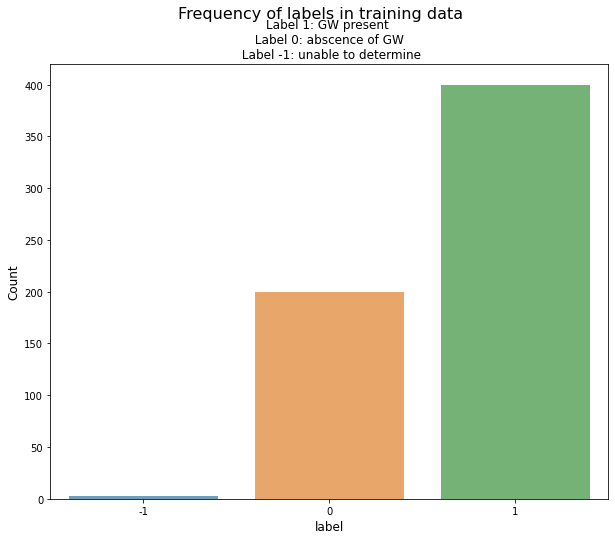

In [13]:
### Plot the distribution of labels ###
label_count  = train_labels['target'].value_counts()
plt.figure(figsize=(10,8))
sns.barplot(x=label_count.index, y=label_count.values, alpha=0.7)
plt.suptitle('Frequency of labels in training data', fontsize=16)
plt.title(f'Label 1: GW present \n Label 0: abscence of GW \n Label -1: unable to determine', fontsize=12, horizontalalignment='center')
plt.ylabel('Count', fontsize=12)
plt.xlabel('label', fontsize=12)
plt.show()

In [14]:
def plot_spectograms(data):
# Spectrogram plot for detector SFT (both real & img)

    fig, ax = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f"Label {data['label']}")
    for ind, detector in enumerate(['L1', 'H1']):
        ax[ind][0].set(xlabel="Timestamps [GPS]",
                         ylabel="Frequency [Hz]",
                         title=f"{detector} - Real part")
        ax[ind][1].set(xlabel="Timestamps [GPS]",
                         ylabel="Frequency [Hz]",
                         title=f"{detector} - Imaginary part")
        
        c0 = ax[ind][0].pcolormesh(data[f"{detector}_ts"], data['freq'],
                                     data[f"{detector}_SFTs_amplitudes"].real)
        c1 = ax[ind][1].pcolormesh(data[f"{detector}_ts"], data['freq'],
                                     data[f"{detector}_SFTs_amplitudes"].imag)
    
        fig.colorbar(c0, ax=ax[ind][0])
        fig.colorbar(c1, ax=ax[ind][1])
        
    plt.show()

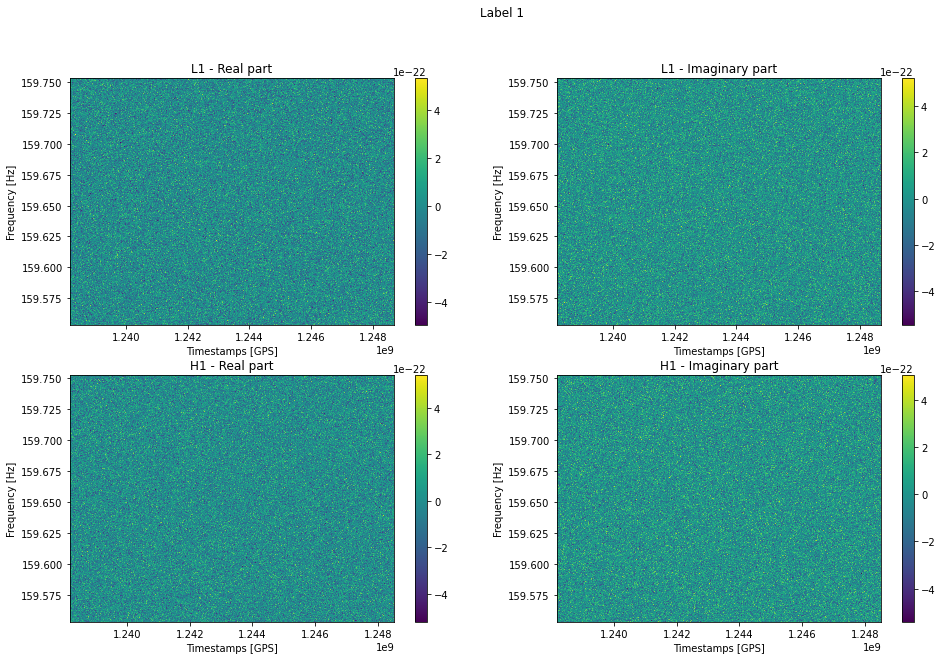

In [15]:
data = extract_data_from_hdf5(train_example_with_signal_path, train_labels)
plot_spectograms(data)

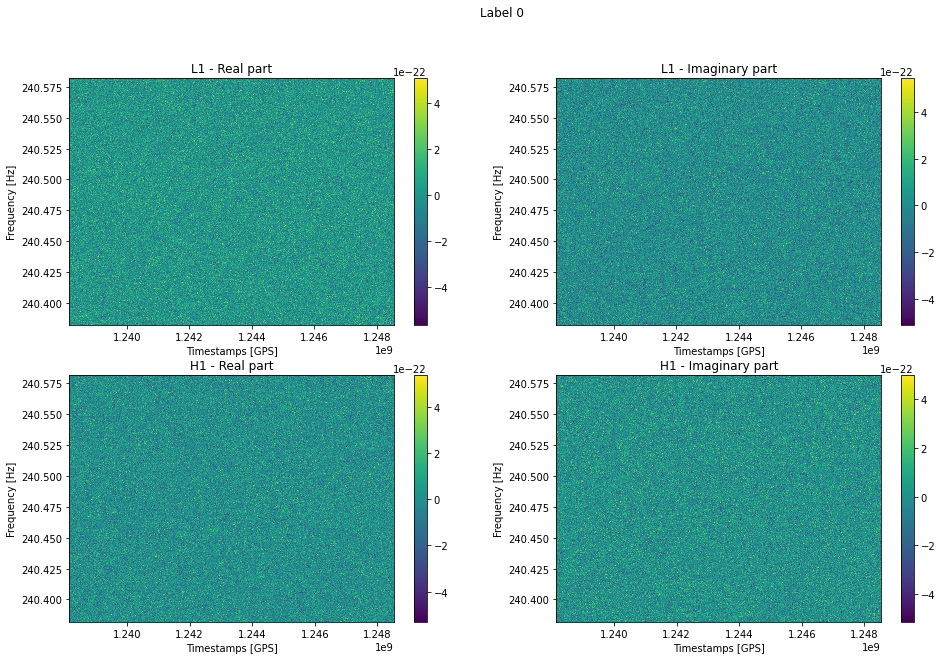

In [16]:
data = extract_data_from_hdf5(train_example_without_signal_path, train_labels)
plot_spectograms(data)

## Time Domain Data Prep
- Freq --> Time: Inverse Fourier Transform
- IFT method: Overlap Add Method (OLA)
- [wikipedia](https://en.wikipedia.org/wiki/Overlap%E2%80%93add_method)

In [17]:
data_s = extract_data_from_hdf5(train_example_with_signal_path, train_labels)
data_ws = extract_data_from_hdf5(train_example_without_signal_path, train_labels)
    
amp1 = data_s['L1_SFTs_amplitudes']
f1 = data_s['freq']
f_m1 = sum(f1)/len(f1)
print('mean(label1) {f_m1}')

amp2 = data_ws['L1_SFTs_amplitudes']
f2 = data_ws['freq']
f_m2 = sum(f2)/len(f2)
print(f'mean(label0) {f_m2}')

mean(label1) {f_m1}
mean(label0) 240.48194444444454


In [18]:
from scipy import signal
from scipy.signal import istft

# istft (short time forurier transform): used to reconstruct time_domain from freq_domain
# basically inverse fourier transform
_, xrec1 = signal.istft(amp1, f_m1)
_, xrec2 = signal.istft(amp2, f_m2)

# resampling the sample at 16707
xrec1_r = signal.resample(xrec1, 16707)
xrec2_r = signal.resample(xrec2, 16707)

print(f'Signal size (freq_domain) {amp1[0].shape[0]}')
print(f'Signal size (Time_domain) {xrec1.shape[0]}')
print(f'Signal size (Time_domain) (resamples) {xrec1_r.shape[0]}')

Signal size (freq_domain) 4655
Signal size (Time_domain) 1670786
Signal size (Time_domain) (resamples) 16707


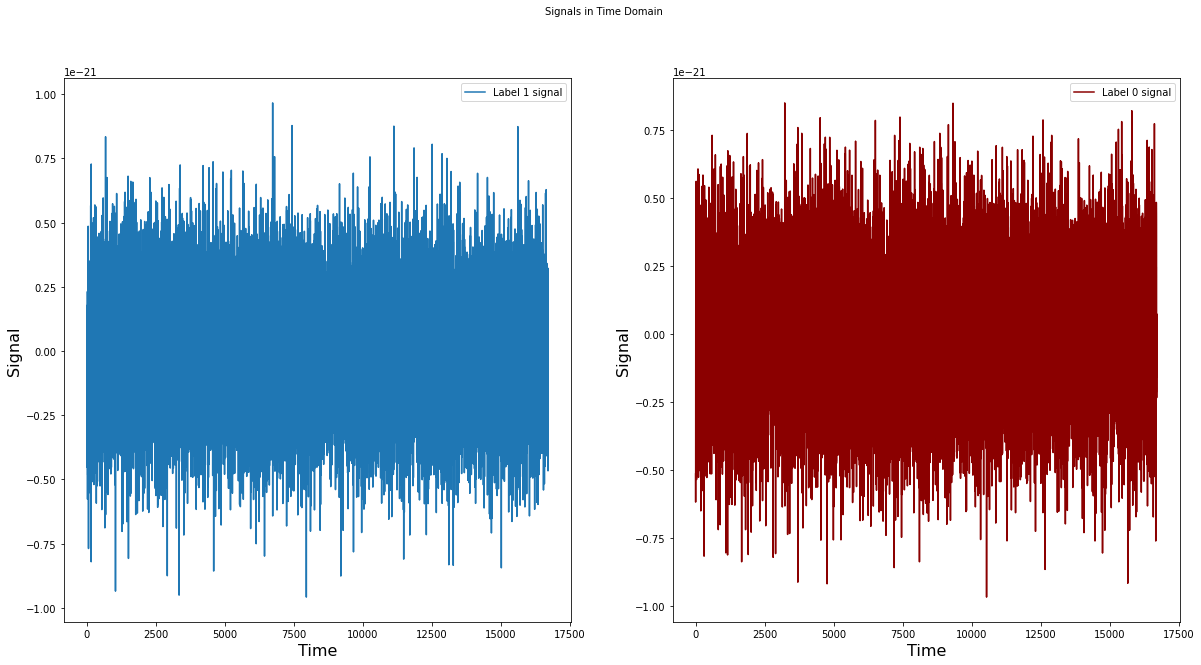

In [19]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.suptitle('Signals in Time Domain', fontsize=10)
plt.ylabel('Signal', fontsize=16)
plt.xlabel('Time', fontsize=16)

plt.plot(xrec1_r, label='Label 1 signal')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Signal', fontsize=16)
plt.xlabel('Time', fontsize=16)

plt.plot(xrec2_r, label='Label 0 signal', c = 'darkred')

plt.legend(loc='upper right')

In [20]:
from tqdm.notebook import tqdm
# %%time
time_df = pd.DataFrame()
for p in tqdm(os.listdir(TRAIN_PATH), total=len(os.listdir(TRAIN_PATH))):
    final_data = dict()
    data = extract_data_from_hdf5(DATA_PATH/'train'/p, train_labels)
    amp1 = data['L1_SFTs_amplitudes']
    amp2 = data['H1_SFTs_amplitudes']
    f = data['freq']
    label = data['label']
    f_m = sum(f)/len(f)
    _, xrec1 = signal.istft(amp1, f_m)
    _, xrec2 = signal.istft(amp2, f_m)
    xrec1_r = signal.resample(xrec1, 16707)
    xrec2_r = signal.resample(xrec2, 16707)
    final_data['L1_resampled_time'] = xrec1_r
    final_data['H1_resampled_time'] = xrec2_r
    final_data['label'] = label
    time_df = time_df.append(final_data, ignore_index=True)

  0%|          | 0/603 [00:00<?, ?it/s]

In [21]:
time_df = time_df.sample(frac=1.0)
time_df.shape

(603, 3)

In [22]:
time_df.head(10)

L1_resampled_time  \
202  [-1.5009606e-22, 2.543657e-22, -2.3443724e-22,...   
182  [1.6213622e-22, 1.3377651e-22, 5.0366263e-23, ...   
471  [3.5190497e-22, -3.0813442e-22, -1.3542481e-22...   
152  [1.5665713e-23, -1.9087121e-22, -2.6154293e-22...   
400  [-5.46765e-23, -8.106585e-23, 6.024424e-23, -1...   
249  [7.206944e-23, -4.0557138e-23, 1.7160408e-22, ...   
193  [1.8638826e-22, -4.3091723e-22, -1.1053696e-22...   
5    [-1.9738069e-22, 4.714782e-22, 9.688866e-23, -...   
410  [-8.445154e-23, -3.0744873e-22, -6.953436e-22,...   
84   [-6.873669e-23, -2.618157e-22, -1.998882e-22, ...   

                                     H1_resampled_time  label  
202  [2.3919728e-23, -3.2908617e-23, 8.218452e-23, ...    1.0  
182  [-2.8523133e-22, 3.8934408e-22, -2.3988544e-23...    1.0  
471  [-1.4951842e-22, 4.5595277e-22, 3.865611e-22, ...    1.0  
152  [2.2842726e-22, -9.154766e-23, -7.105478e-23, ...    1.0  
400  [-2.3556205e-22, -1.8327891e-22, -5.280469e-23...    1.0  
249  [-1.1341101e-22, 3.2034462e-22, -2.1398252e-22...    1.0  
193  [-2.2737223e-22, -4.161374e-22, 1.2386184e-22,...    1.0  
5    [-3.026759e-22, 3.3225963e-22, -2.3616322e-22,...    1.0  
410  [-2.1159854e-23, -4.0742347e-23, -2.514244e-22...    1.0  
84   [2.126471e-22, -2.5340886e-22, -3.3000543e-22,...    1.0

In [23]:
train_df = pd.DataFrame()
for p in tqdm(os.listdir(TRAIN_PATH), total=len(os.listdir(TRAIN_PATH))):
    data = extract_data_from_hdf5_reduced(DATA_PATH/'train'/p, train_labels)
    train_df = train_df.append(data, ignore_index=True)

  0%|          | 0/603 [00:00<?, ?it/s]

In [24]:
train_df.head(10)

id                                               freq  \
0  0517ef7fe  [99.72777777777777, 99.72833333333332, 99.7288...   
1  09531cde3  [383.4066666666667, 383.40722222222223, 383.40...   
2  067b3fb4b  [415.4405555555556, 415.4411111111111, 415.441...   
3  4f61f078b  [247.44722222222222, 247.4477777777778, 247.44...   
4  7c2e38128  [424.7238888888889, 424.72444444444443, 424.72...   
5  3c89d38a7  [99.63555555555556, 99.6361111111111, 99.63666...   
6  9e811dd88  [171.50166666666667, 171.50222222222223, 171.5...   
7  4c540bb3b  [391.88, 391.88055555555553, 391.8811111111111...   
8  e877b6a70  [159.1927777777778, 159.19333333333333, 159.19...   
9  5b9f01d0f  [297.34, 297.3405555555555, 297.3411111111111,...   

                                               L1_ts  \
0  [1238178603, 1238180403, 1238182203, 123818400...   
1  [1238171878, 1238173678, 1238175478, 123817727...   
2  [1238174562, 1238188464, 1238190264, 123819206...   
3  [1238171750, 1238173550, 1238175350, 123817715...   
4  [1238171138, 1238172938, 1238174738, 123817653...   
5  [1238170206, 1238172006, 1238173806, 123817560...   
6  [1238167312, 1238169112, 1238170912, 123817271...   
7  [1238166825, 1238176228, 1238178028, 123817982...   
8  [1238168697, 1238170497, 1238172297, 123817439...   
9  [1238175857, 1238182097, 1238182728, 123819455...   

                                               H1_ts  label  
0  [1238170914, 1238175422, 1238177222, 123817902...    1.0  
1  [1238166446, 1238168246, 1238170046, 123817184...    1.0  
2  [1238177971, 1238179771, 1238184917, 123818671...    1.0  
3  [1238168490, 1238170290, 1238172090, 123817389...    1.0  
4  [1238188274, 1238190074, 1238191874, 123819367...    1.0  
5  [1238176460, 1238178260, 1238195076, 123819687...    1.0  
6  [1238167805, 1238169605, 1238181101, 123818180...    1.0  
7  [1238166795, 1238168595, 1238170395, 123817219...    1.0  
8  [1238175439, 1238177239, 1238179039, 123818083...    0.0  
9  [1238168200, 1238170000, 1238171800, 123817360...    0.0

In [25]:
train_df = train_df.loc[train_df['label'] != -1]

## Freq Distribution

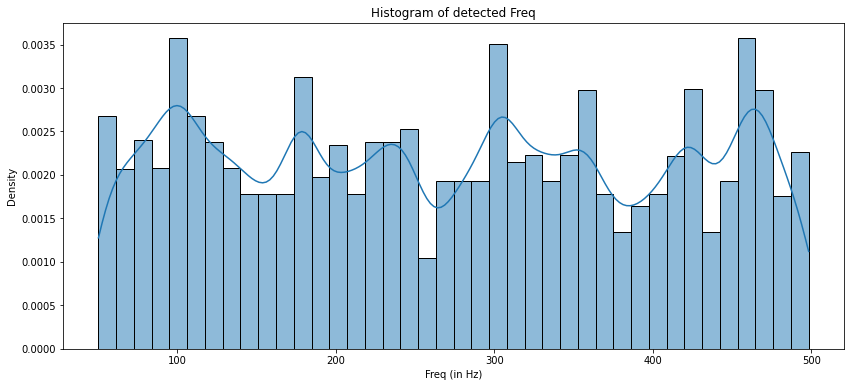

In [26]:
plt.figure(figsize=(14,6))
sns.histplot(x=list(np.hstack(train_df['freq'])), stat="density", common_norm=False, bins=40, kde=True)
plt.title('Histogram of detected Freq');
plt.xlabel('Freq (in Hz)')
plt.show()

## Time Stamp Sampling

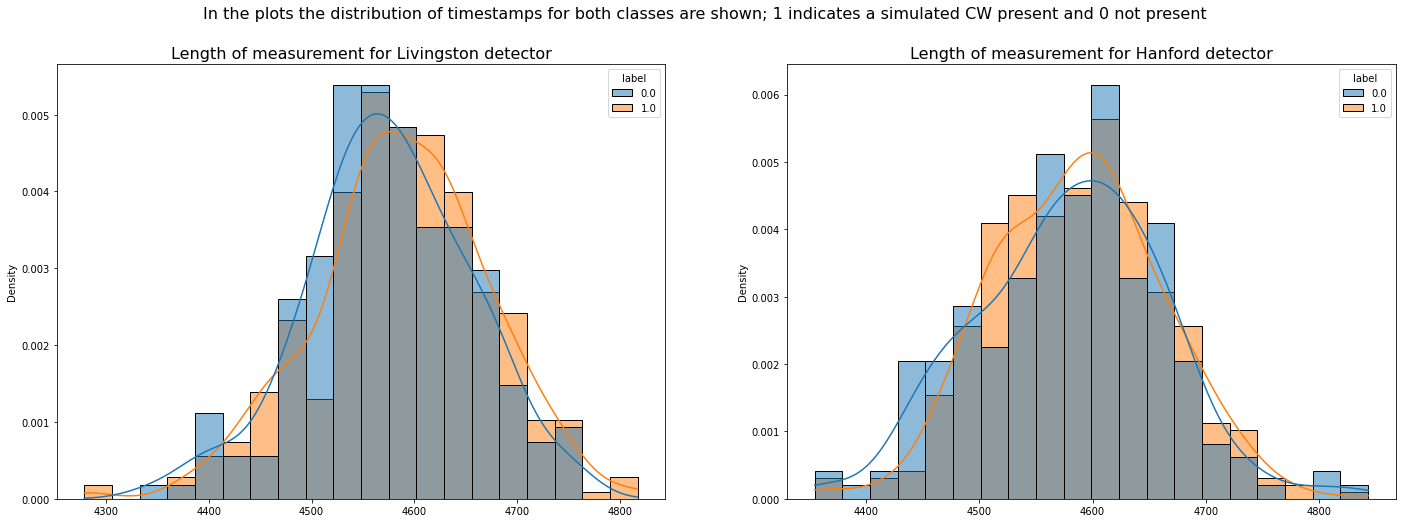

In [27]:
fig, ax = plt.subplots(1,2, figsize=(24,8))
fig.suptitle(f"In the plots the distribution of timestamps for both classes are shown; 1 indicates a simulated CW present and 0 not present", fontsize=16)
sns.histplot(x=list(len(i) for i in train_df['L1_ts']),
             hue=train_df['label'],
             stat="density", # sets the y-axis of the histogram to display the density estimation rather than the count of occurrences
             common_norm=False, # False ensures separate normalizations for each bar.
             bins=20, 
             # ax: axes object where the histogram should be plotted
             # ax[0]: first subplot axes in a multi-plot setup
             ax=ax[0], 
             kde=True).set_title('Length of measurement for Livingston detector', fontsize=16);

sns.histplot(
        x=list(len(i) for i in train_df['H1_ts']),hue= train_df['label'], 
        stat="density", common_norm=False, bins=20, ax=ax[1], kde=True).set_title('Length of measurement for Hanford detector', fontsize=16);

## Simulating GW
* riroriro: python lib to simlate graviation wave for BBH or BNS merger 
* [Paper](https://arxiv.org/abs/2103.06943)
* [Python Lib](https://pypi.org/project/riroriro/)
* [DOcumentation](https://wvanzeist.github.io/riroriro/gwexporter.html)

In [28]:
# Code by Geir Drange https://www.kaggle.com/code/mistag/reverse-engineering-create-clean-gw-sign

import riroriro.inspiralfuns as ins
import riroriro.mergerfirstfuns as me1
import riroriro.matchingfuns as mat
import riroriro.mergersecondfuns as me2

'''
Parameters:
    logMC: system mass (0.0-2.0)
    q: mass ratio (0.1-1.0)
    D: distance (Mpc)
    merger_type: 'BH'=binary black hole merger, 'NS'=binary neutron star merger
    flow: low frequency (Hz)
'''

def gen_gw(logMc=1.4, q=0.8, D=100.0, flow=10.0, merger_type='BH'):
    M, eta = ins.get_M_and_eta(logMc=logMc,q=q)
    start_x = ins.startx(M,flow)
    end_x = ins.endx(eta,merger_type)
    x, xtimes, dt = ins.PN_parameter_integration(start_x,end_x,M,eta)
    realtimes = ins.inspiral_time_conversion(xtimes,M)
    i_phase, omega, freq = ins.inspiral_phase_freq_integration(x,dt,M)
    r, rdot = ins.radius_calculation(x,M,eta)
    A1, A2 = ins.a1_a2_calculation(r,rdot,omega,D,M,eta)
    i_Aorth, i_Adiag = ins.inspiral_strain_polarisations(A1,A2,i_phase)
    i_amp = ins.inspiral_strain_amplitude(i_Aorth,i_Adiag)
    i_time = realtimes
    i_omega = omega
    sfin, wqnm = me1.quasi_normal_modes(eta)
    alpha, b, C, kappa = me1.gIRS_coefficients(eta,sfin)
    fhat, m_omega = me1.merger_freq_calculation(wqnm,b,C,kappa)
    fhatdot = me1.fhat_differentiation(fhat)
    m_time = me1.merger_time_conversion(M)
    min_switch_ind = mat.min_switch_ind_finder(i_time,i_omega,m_time,m_omega)
    final_i_index = mat.final_i_index_finder(min_switch_ind,i_omega,m_omega)
    time_offset = mat.time_offset_finder(min_switch_ind,final_i_index,i_time,m_time)
    i_m_time, i_m_omega = mat.time_frequency_stitching(min_switch_ind,final_i_index,time_offset,i_time,i_omega,m_time,m_omega)
    i_m_freq = mat.frequency_SI_units(i_m_omega,M)
    m_phase = me2.merger_phase_calculation(min_switch_ind,final_i_index,i_phase,m_omega)
    i_m_phase = me2.phase_stitching(final_i_index,i_phase,m_phase)
    m_amp = me2.merger_strain_amplitude(min_switch_ind,final_i_index,alpha,i_amp,m_omega,fhat,fhatdot)
    i_m_amp = me2.amplitude_stitching(final_i_index,i_amp,m_amp)
    m_Aorth, m_Adiag = me2.merger_polarisations(final_i_index,m_amp,m_phase,i_Aorth)
    i_m_Aorth, i_m_Adiag = me2.polarisation_stitching(final_i_index,i_Aorth,i_Adiag,m_Aorth,m_Adiag)
    return np.array(i_m_time), np.array(i_m_Aorth), np.array(i_m_Adiag), np.array(i_m_freq)

In [29]:
'''
function return two orthogonal waves which are non-linear and need to be resampled at 2048 Hz
Parameters:
- dt: time series
- amp: amplitude signal
- seg: output sequence length (seconds)
'''

SR = 2048 # target sample rate (Hz)
def resample(dt, amp, seg=2.0):
    end = dt[-1]
    start = end - seg
    d = np.zeros(int(SR*seg))
    for i in range((int(SR*seg))):
        t = start + i/SR
        d[i] = amp[np.where(dt == dt[np.abs(dt-t).argmin()])[0][0]]
    return d

In [30]:
def plot_sig(dt, sig1, sig2=None, seg=2.0):
    end = dt[-1]
    start = end - seg
    plt.figure(1)
    plt.plot(dt, sig1)
    peak = np.max(np.abs(sig1))
    plt.axis([start,end,np.min(sig1)-peak/10,np.max(sig1)+peak/10])
    if sig2 is not None:
        plt.plot(dt, sig2)
    plt.xlabel('Time (s)')
    plt.ylabel('Strain amplitude')


## Test SIgnal Generation

In [31]:
m_time, m_Aorth, m_Adiag, m_freq = gen_gw(logMc=1.4, q=0.2)

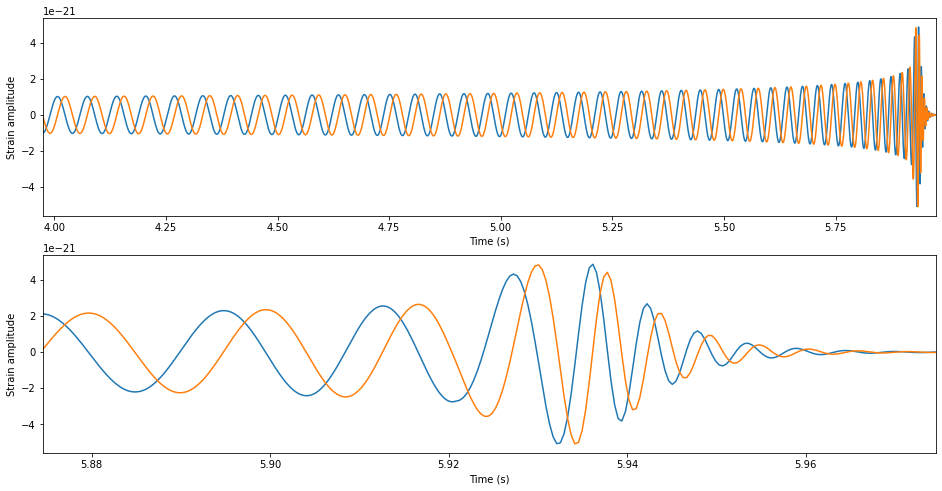

In [32]:
fig = plt.figure(figsize=(16,8))
plt.subplot(2, 1, 1)
plot_sig(m_time, m_Aorth, m_Adiag, seg=2)
plt.subplot(2, 1, 2)
plot_sig(m_time, m_Aorth, m_Adiag, seg=.1)


## Resample the signal to 2048Hz

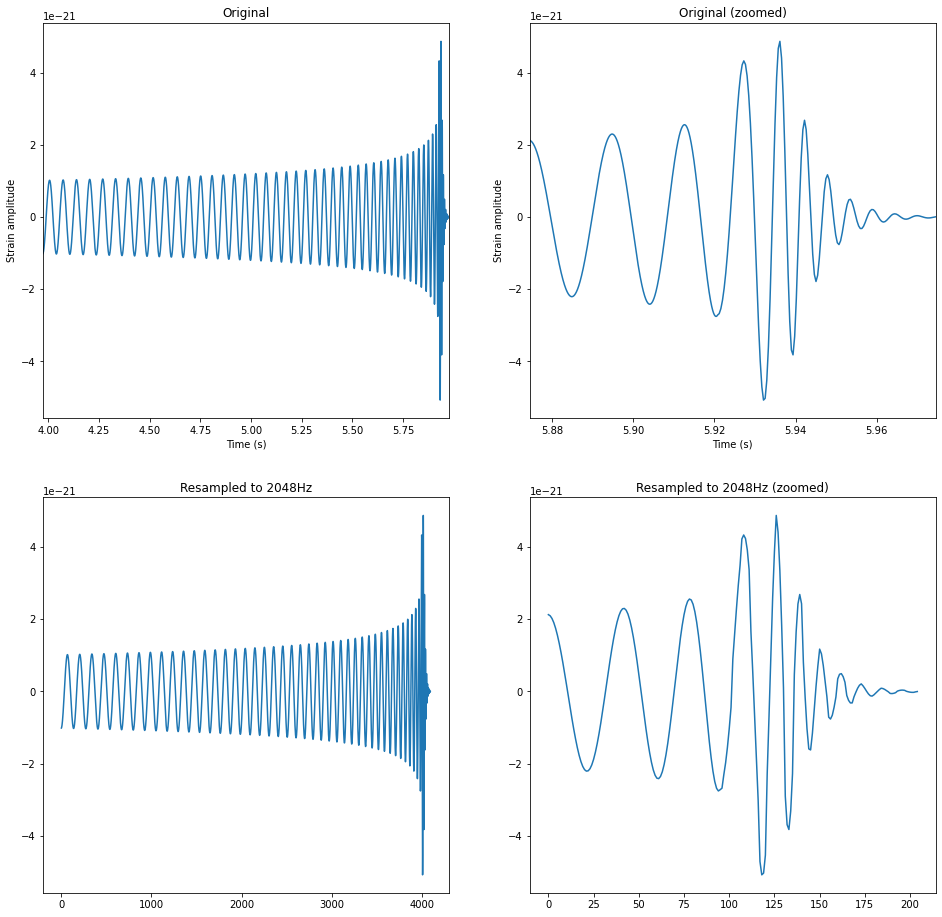

In [33]:
d1 = resample(m_time, m_Aorth, 2.0)

fig = plt.figure(figsize=(16,16))
plt.subplot(2, 2, 1)
plot_sig(m_time, m_Aorth, seg=2)
plt.title('Original')
plt.subplot(2, 2, 2)
plot_sig(m_time, m_Aorth, seg=.1)
plt.title('Original (zoomed)')
plt.subplot(2, 2, 3)
plt.plot(d1)
plt.title('Resampled to 2048Hz')
plt.subplot(2, 2, 4)
plt.plot(d1[-205:])
plt.title('Resampled to 2048Hz (zoomed)');

## Visaluzing Freq Vector

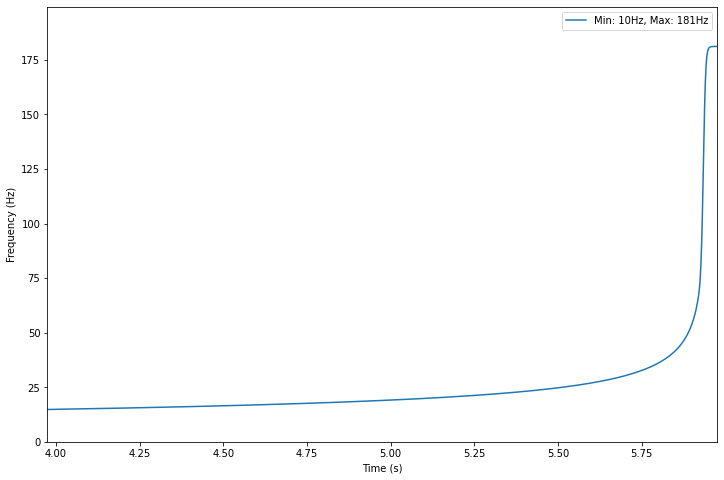

In [34]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(m_time, m_freq, label="Min: {}Hz, Max: {}Hz".format(int(np.min(m_freq)), int(np.max(m_freq))))
peak = np.max(np.abs(m_freq))
plt.axis([m_time[-1] - 2.0 if m_time[-1] >= 2.0 else m_time[0], m_time[-1], 0 , np.max(m_freq)+peak/10])
ax.legend()
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)');

Text(0.5, 1.0, 'Constant-Q power spectrum')

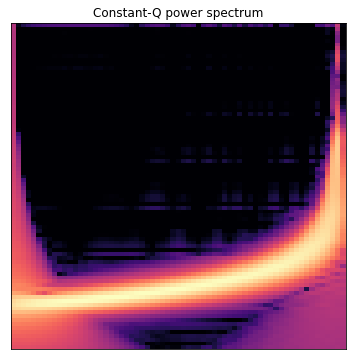

In [36]:
# hop_len: spacing between consecutive frames of a audio signal
hop_length = 64 
C = np.abs(librosa.cqt(d1/np.max(d1), sr=SR, hop_length=hop_length, fmin=8, filter_scale=0.8, bins_per_octave=12))
fig, ax = plt.subplots(figsize=(6,6))
img = librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                               sr=SR*2, hop_length=hop_length, bins_per_octave=12, ax=ax)
ax.set_title('Constant-Q power spectrum')

In consta-Q spectral plot
* signal is normalized by dividing it by its maximum value (smax) before passing it to the CQT function
* CQT is computed using SR, fmin, filter_scale, bin_per_octave
* CQT values are converted to a logarithmic scale in decibels using `librosa.amplitude_to_db`

`mpc` --> unit used to measure astronomical distance

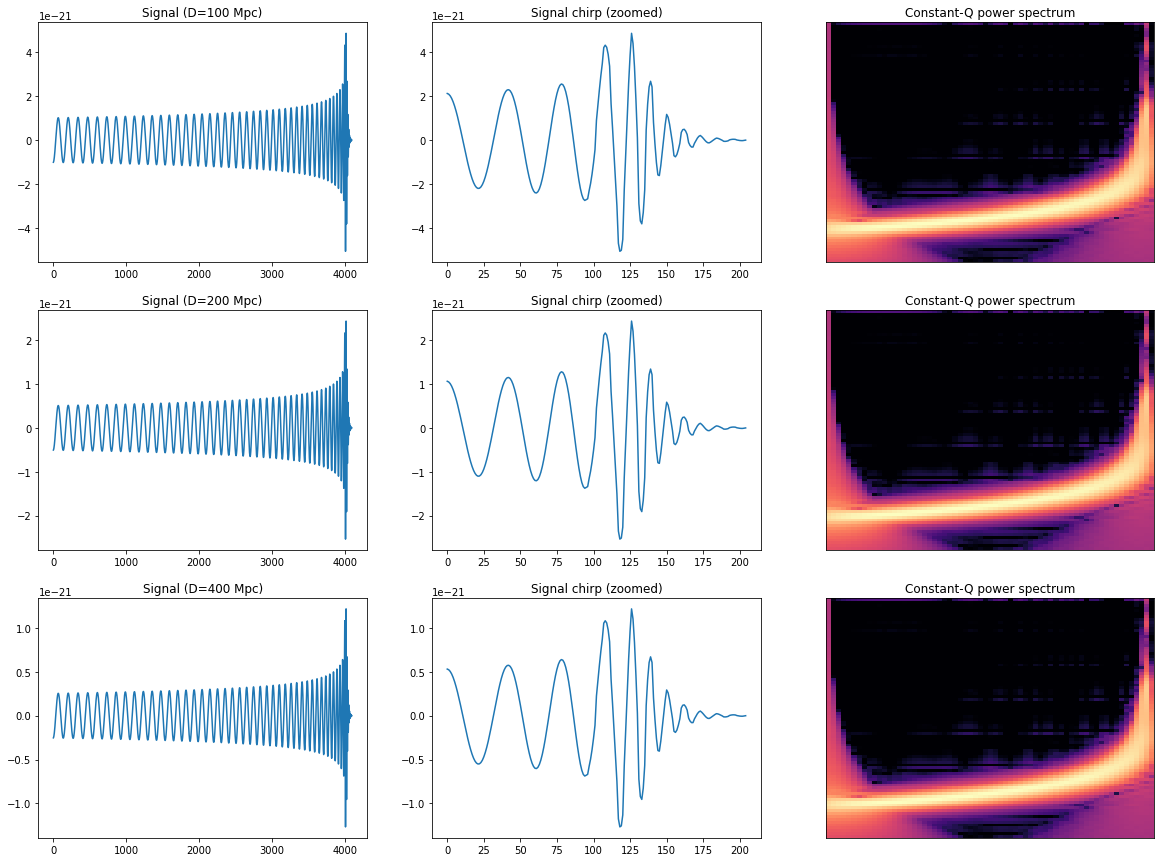

In [37]:
hop_length = 64

fig = plt.figure(figsize=(20,15))
dist = [100., 200., 400.]
for m in range(len(dist)):
    m_time, m_Aorth, _, m_freq = gen_gw(logMc=1.4, q=0.2, D=dist[m])
    rd = resample(m_time, m_Aorth, 2.0)
    # time series
    ax = plt.subplot(len(dist), 3, 1+m*3)
    plt.plot(rd)
    plt.title('Signal (D={} Mpc)'.format(int(dist[m])))
    # zoomed times series (chirp)
    ax = plt.subplot(len(dist), 3, 2+m*3)
    plt.plot(rd[-205:])
    plt.title('Signal chirp (zoomed)')
    # Q-Transform
    ax = plt.subplot(len(dist), 3, 3+m*3)
    if m == 0:
        smax = np.max(rd)
    C = np.abs(librosa.cqt(rd/smax, sr=SR, hop_length=hop_length, fmin=8, filter_scale=0.8, bins_per_octave=12))
    if m == 0:
        Cmax = np.max(C)
    img = librosa.display.specshow(librosa.amplitude_to_db(C, ref=Cmax), # was np.max
                                   sr=SR*2, hop_length=hop_length, bins_per_octave=12, ax=ax)
    ax.set_title('Constant-Q power spectrum');

can be observed from the above graphs, gw doesn't follow inverse sqaure law
i.e. unlike other energy wavess (like em) the intensity of gw does decrease with time. Instead, gw causes the stetching of space itself. Hence, the amp(GW) remain consta

### Generating Continuous GW data
* [Ref_notebook](https://www.kaggle.com/code/rodrigotenorio/generating-continuous-gravitational-wave-signals)
* code for generation has been taken from above nb

In [38]:
# Generate signals with parameters drawn from a specific population
num_signals = 2

# These parameters describe background noise and data format
writer_kwargs = {
                "tstart": 1238166018,
                "duration": 4 * 30 * 86400,  
                "detectors": "H1,L1",        
                "sqrtSX": 1e-23,          
                "Tsft": 1800,             
                "SFTWindowType": "tukey", 
                "SFTWindowBeta": 0.01,
               }

In [41]:
# This class allows us to sample signal parameters from a specific population.
# Implicitly, sky positions are drawn uniformly across the celestial sphere.
# PyFstat also implements a convenient set of priors to sample a population
# of isotropically oriented neutron stars.
signal_parameters_generator = pyfstat.AllSkyInjectionParametersGenerator(
    priors={
        "tref": writer_kwargs["tstart"],
        "F0": {"uniform": {"low": 100.0, "high": 100.1}},
        "F1": lambda: 10**stats.uniform(-12, 4).rvs(),
        "F2": 0,
        "h0": lambda: writer_kwargs["sqrtSX"] / stats.uniform(1, 10).rvs(),
        **pyfstat.injection_parameters.isotropic_amplitude_priors,
    },
)

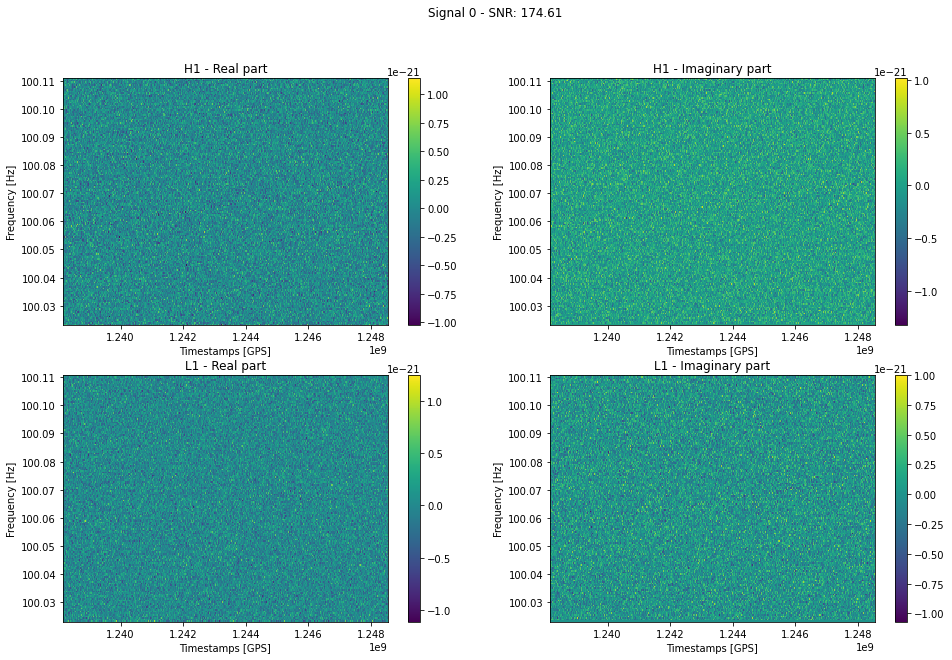

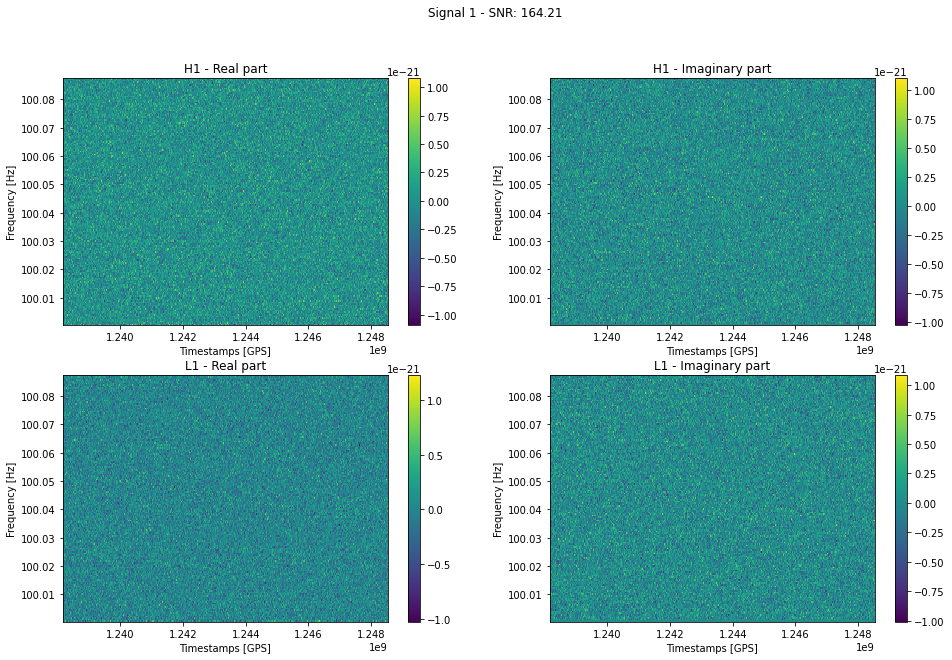

In [42]:
snrs = np.zeros(num_signals)

for ind in range(num_signals):

    # Draw signal parameters.
    # Noise can be drawn by setting `params["h0"] = 0
    params = signal_parameters_generator.draw()
    writer_kwargs["outdir"] = f"PyFstat_example_data_ensemble/Signal_{ind}"
    writer_kwargs["label"] = f"Signal_{ind}"
    
    writer = pyfstat.Writer(**writer_kwargs, **params)
    writer.make_data()
    
    # SNR can be compute from a set of SFTs for a specific set
    # of parameters as follows:
    snr = pyfstat.SignalToNoiseRatio.from_sfts(
        F0=writer.F0, sftfilepath=writer.sftfilepath
    )
    squared_snr = snr.compute_snr2(
        Alpha=writer.Alpha, 
        Delta=writer.Delta,
        psi=writer.psi,
        phi=writer.phi, 
        h0=writer.h0,
        cosi=writer.cosi
    )
    snrs[ind] = np.sqrt(squared_snr)
    
    # Data can be read as a numpy array using PyFstat
    frequency, timestamps, amplitudes = pyfstat.utils.get_sft_as_arrays(
        writer.sftfilepath
    )
    
    fig, ax = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f"Signal {ind} - SNR: {snrs[ind]:.2f}")
    for d_ind, detector in enumerate(amplitudes.keys()):
        ax[d_ind][0].set(xlabel="Timestamps [GPS]",
                         ylabel="Frequency [Hz]",
                         title=f"{detector} - Real part")
        ax[d_ind][1].set(xlabel="Timestamps [GPS]",
                         ylabel="Frequency [Hz]",
                         title=f"{detector} - Imaginary part")
        
        c0 = ax[d_ind][0].pcolormesh(timestamps[detector], frequency,
                                     amplitudes[detector].real)
        c1 = ax[d_ind][1].pcolormesh(timestamps[detector], frequency,
                                     amplitudes[detector].imag)
        
        fig.colorbar(c0, ax=ax[d_ind][0])
        fig.colorbar(c1, ax=ax[d_ind][1])
    plt.show()

## LSTM for Time Domain
* LSTM > RNN : 
* LSTM are better at learning from Time Series dataset

In [45]:
X_l = np.asarray(time_df['L1_resampled_time'].to_list())
X_h = np.asarray(time_df['H1_resampled_time'].to_list())
y = np.asarray(time_df['label'].to_list())

X_l = np.expand_dims(X_l, axis=1)
X_h = np.expand_dims(X_h, axis=1)

print(f"X_l.shape {X_l.shape}")
print(f"X_h.shape {X_h.shape}")

X_l.shape (603, 1, 16707)
X_h.shape (603, 1, 16707)


##### return_sequence: 

##### regularization 
* technique used to prevent overfitting 
1. l1 & l2 reg (weight decay) --> encourages the nw weights to small
    * L1_reg: sum of abs values of loss funct
    * L2_reg: sum of sq_wt
2. Dropout --> randomly drop neurons during training only......helps in generalization
3. activity_regularizer --> 

In [49]:
def create_lstm(x_input):
        
    lstm = tf.keras.Sequential([
        
        tf.keras.layers.LSTM(128, kernel_initializer='normal',input_shape=(1, X_l.shape[2]), return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.LSTM(128, kernel_initializer='normal', return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.LSTM(128, kernel_initializer='normal', return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(units=128, kernel_initializer='normal', activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), 
                          bias_regularizer=regularizers.L2(1e-2),
                          activity_regularizer=regularizers.L2(1e-3)),
        tf.keras.layers.Dropout(0.5)
    ])
    
    features = lstm(x_input)
    x = layers.Dense(256, activation='relu')(features)
    return x

In [50]:
def get_lstm_model():
    # 1) Hanford 
    h_input = tf.keras.layers.Input(shape=(1,X_l.shape[2]), name='x_h')
    # 2) Livingston 
    l_input = tf.keras.layers.Input(shape=(1, X_l.shape[2]), name='x_l')
    
    h_out = create_lstm(h_input)
    l_out = create_lstm(l_input)

    # Concatenate embeddings
    x = tf.keras.layers.Concatenate()([h_out, l_out])
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, kernel_initializer='normal')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    # Target prediction in range [0,1] with sigmoid activation
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    # Model
    inputs = [h_input, l_input]
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    
    optimizer = 'adam'

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics = [
            tf.keras.metrics.AUC() ,
        ]
    )
    return model

In [53]:
tf.keras.backend.clear_session()
gc.collect()
lstmmodel = get_lstm_model()
print(lstmmodel.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_h (InputLayer)                [(None, 1, 16707)]   0                                            
__________________________________________________________________________________________________
x_l (InputLayer)                [(None, 1, 16707)]   0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1, 128)       8899712     x_h[0][0]                        
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1, 128)       8899712     x_l[0][0]                        
______________________________________________________________________________________________

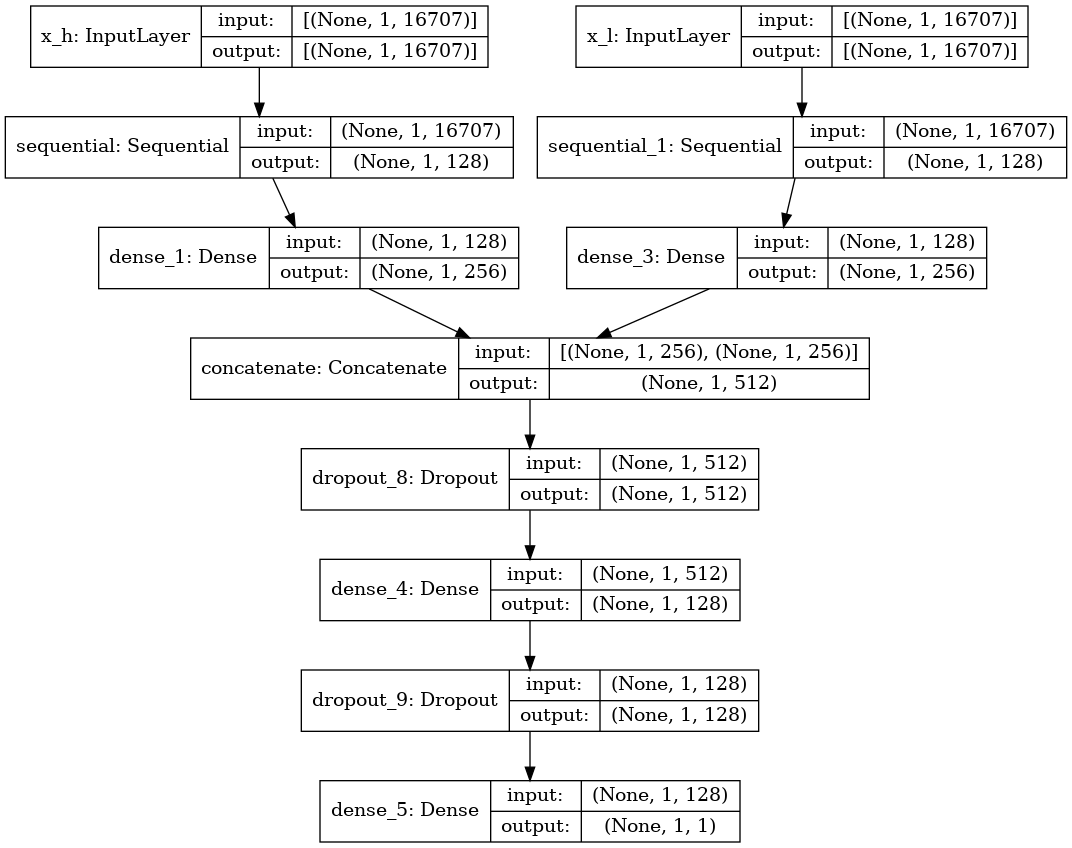

In [55]:
plot_model(lstmmodel, show_shapes=True, show_layer_names=True, to_file="lstmmodel.png")

In [56]:
lstmhistory = lstmmodel.fit(
        x=[X_l, X_h],
        y=y,
        epochs = 50,
        validation_split=0.2,
        verbose = 1,
    )

Epoch 1/50
16/16 [==============================] - 15s 271ms/step - loss: 1.8163 - auc: 0.4940 - val_loss: 1.5897 - val_auc: 0.4868
Epoch 2/50
16/16 [==============================] - 1s 67ms/step - loss: 1.3747 - auc: 0.4943 - val_loss: 1.2526 - val_auc: 0.4868
Epoch 3/50
16/16 [==============================] - 1s 66ms/step - loss: 1.0803 - auc: 0.5041 - val_loss: 1.0053 - val_auc: 0.5000
Epoch 4/50
16/16 [==============================] - 1s 66ms/step - loss: 0.8894 - auc: 0.5136 - val_loss: 0.8688 - val_auc: 0.5000
Epoch 5/50
16/16 [==============================] - 1s 66ms/step - loss: 0.7708 - auc: 0.5100 - val_loss: 0.7826 - val_auc: 0.5000
Epoch 6/50
16/16 [==============================] - 1s 64ms/step - loss: 0.7055 - auc: 0.5034 - val_loss: 0.7368 - val_auc: 0.5000
Epoch 7/50
16/16 [==============================] - 1s 69ms/step - loss: 0.6664 - auc: 0.5238 - val_loss: 0.7193 - val_auc: 0.5000
Epoch 8/50
16/16 [==============================] - 1s 65ms/step - loss: 0.6528 -

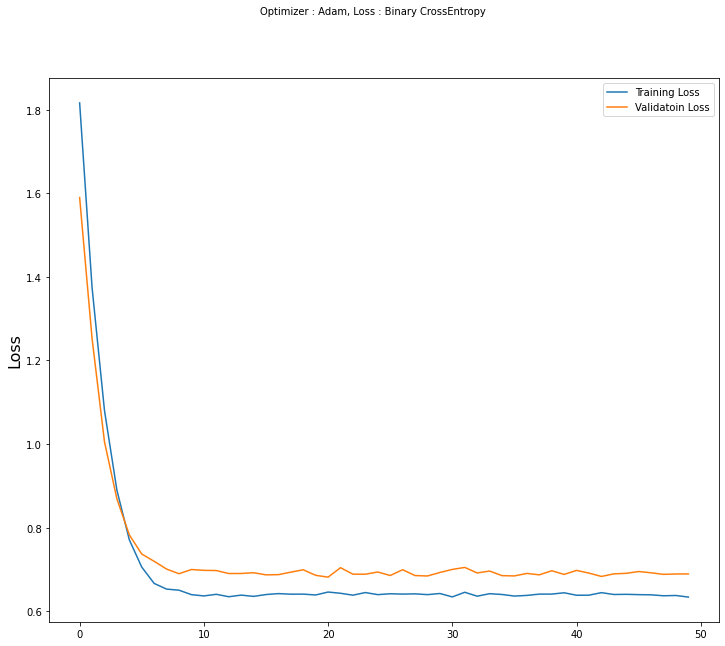

In [57]:
plt.figure(figsize=(12,10))

plt.suptitle('Optimizer : Adam, Loss : Binary CrossEntropy', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(lstmhistory.history['loss'], label='Training Loss')
plt.plot(lstmhistory.history['val_loss'], label='Validatoin Loss')
plt.legend(loc='upper right')

In [62]:
# Releasing Memory
# del time_df, train_df

# Saving Weights
lstmmodel.save_weights('lstmmodel.h5')

# Garbage Collect
# gc.collect()

46